### NiWrap
- NiWrap is a Python Package that provides neuroimaging command-line tools.
- Auto loads and processes data into `respective container` images and gives you the `reference to the output image` in your python code.

pros
- installation of different packages not required
- no need of portforwarding for jupyter server etc.
- abstracts the container and makes using these tools much easier. 

```mermaid
flowchart LR
    A[Python Code] --Input Image--> B[Styx Runner]
    B <--> C[Container]
    E[Boutiques Schema] --> B
    B--Output Image-->A

### Styx runners
- Runners define how commands will be executed and how output files will be stored.
- Different official runners available `LocalRunner`, `DryRunner`, `DockerRunner`, `SingularityRunner` and, `GraphRunner` .
- using default `SingularityRunner` for now, but allows customization.

### Installation

In [5]:
%pip install niwrap styxsingularity

Note: you may need to restart the kernel to use updated packages.


### Setting up the StyxRunner

In [17]:
from styxdefs import set_global_runner
from styxsingularity import SingularityRunner

base = "/ocean/projects/med220004p/bshresth/projects/niwrap-dev"

# Initialize the SingularityRunner with your container images
runner = SingularityRunner(
    images={
        "antsx/ants:v2.5.3" : f"{base}/images/ants_v2.5.3.sif",
        "afni/afni_make_build:AFNI_24.2.06" : f"{base}/images/afni_24.2.06.sif",
        "mcin/fsl:6.0.5": f"{base}/images/fsl_6.0.5.sif"
    }
)

# Set the global runner for Styx
set_global_runner(runner)


### Anatomical Preprocessing

In [15]:
from niwrap import afni
import subprocess

def anat_init(input_image, orientation="RPI"):
    # Make a copy of input image and deoblique it
    subprocess.run(["cp", input_image, "T1w.nii.gz"])
    # Deoblique the image
    afni.v_3drefit(in_file="T1w.nii.gz", deoblique=True)
    # Resample the image to specific orientation
    out = afni.v_3dresample(in_file=input_image, orientation=orientation, prefix="desc-preproc_T1w.nii.gz")
    
    return out

### Input image

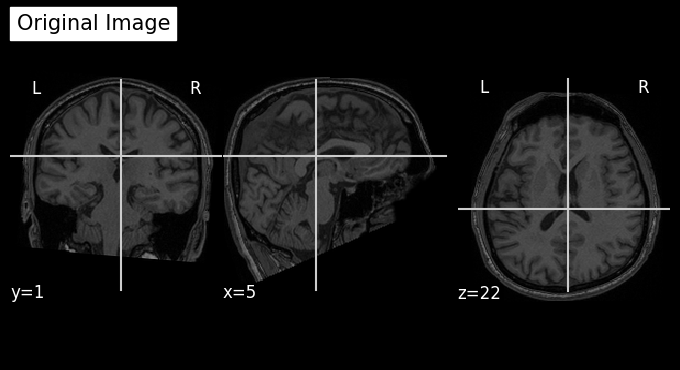

In [9]:
import os
from nilearn.plotting import plot_anat

input_image = os.path.join(base,"data/neurocon/sub-control032014/anat/sub-control032014_T1w.nii.gz")

plot_anat(input_image, title="Original Image", display_mode="ortho")

### Deoblique and resample the image

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/T1w.nii.gz:/styx_input/0/T1w.nii.gz --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_2_3drefit:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/afni_24.2.06.sif /bin/bash /styx_output/run.sh
[D] Running command: 3drefit -deoblique /styx_input/0/T1w.nii.gz


[E] ++ 3drefit: AFNI version=AFNI_24.2.06 (Sep 12 2024) [64-bit]
[E] ++ Authored by: RW Cox
[E] ++ Processing AFNI dataset /styx_input/0/T1w.nii.gz
[E]  + deoblique
[E]  + loading and re-writing dataset /styx_input/0/T1w.nii.gz (/styx_input/0/T1w.nii.gz in NIFTI storage)
[E] ++ 3drefit processed 1 datasets
[I] Executed 3drefit in 0:00:02.870310
[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/data/neurocon/sub-control032014/anat/sub-control032014_T1w.nii.gz:/styx_input/0/sub-control032014_T1w.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_3_3dresample:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/afni_24.2.06.sif /bin/bash /styx_output/run.sh
[D] Running command: 3dresample -inset /styx_input/0/sub-control032014_T1w.nii.gz -orient RPI -prefix desc-preproc_T1w.nii.gz
[E] *+ WARNING:   If you are performing spatial transformations on an 

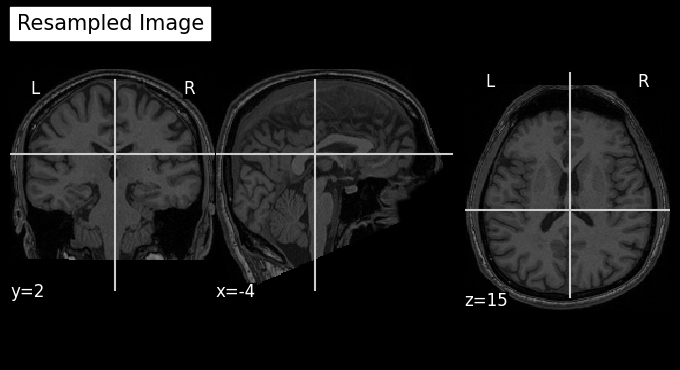

In [19]:
resampled = anat_init(input_image)
plot_anat(resampled.out_file, title="Resampled Image", display_mode="ortho")

### Skullstripping

In [22]:
from niwrap import fsl

def brain_mask_fsl(input_image):
    out = fsl.bet(infile=input_image, binary_mask=True)
    return out

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_3_3dresample/desc-preproc_T1w.nii.gz:/styx_input/0/desc-preproc_T1w.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_4_bet:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/fsl_6.0.5.sif /bin/bash /styx_output/run.sh
[D] Running command: bet /styx_input/0/desc-preproc_T1w.nii.gz img_bet -m
[I] Executed bet in 0:00:04.661119


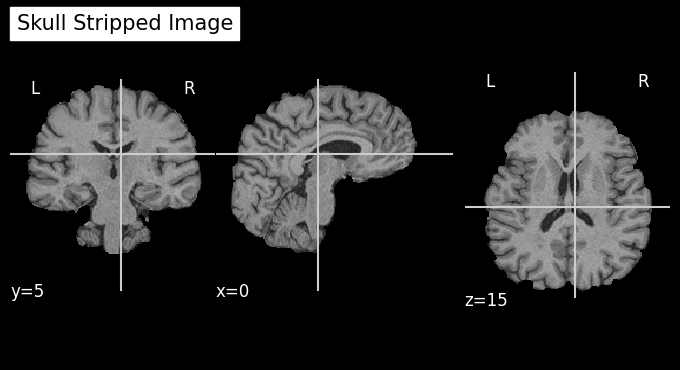

In [23]:
skull_stripped = brain_mask_fsl(resampled.out_file)
skull_stripped_image = skull_stripped.outfile

plot_anat(skull_stripped_image, title="Skull Stripped Image", display_mode="ortho")

Similarly we can use other tools

In [ ]:
# from nodeblocks.anat_preproc import brain_mask_ants
# template_path = os.path.join(base,"oasis_data/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0.nii.gz")
# mask_path=os.path.join(base,"oasis_data/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0_BrainCerebellumProbabilityMask.nii.gz")
# regmask_path =os.path.join(base,"oasis_data/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0_BrainCerebellumRegistrationMask.nii.gz")
# skull_stripped = brain_mask_ants(input_image, template_path, mask_path)
# skull_stripped_image = skull_stripped.brain_extracted_image

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_4_bet/img_bet.nii.gz:/styx_input/0/img_bet.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_5_N4BiasFieldCorrection:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/ants_v2.5.3.sif /bin/bash /styx_output/run.sh
[D] Running command: N4BiasFieldCorrection --image-dimensionality 3 --shrink-factor 2 --input-image /styx_input/0/img_bet.nii.gz --output '[corrected.nii.gz,bias.nii.gz]'
[I] Executed N4BiasFieldCorrection in 0:03:05.195127


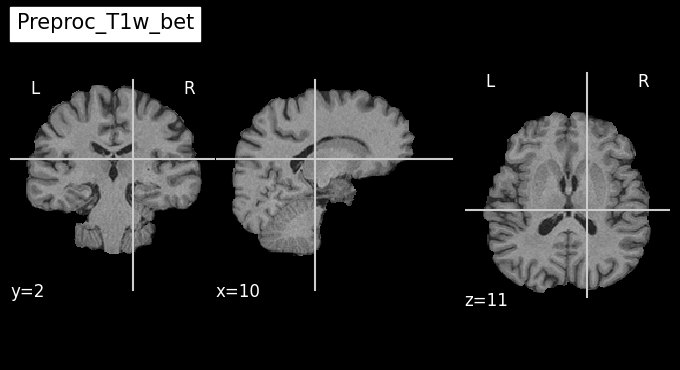

In [25]:
### N4 Bias Field Correction Block ###
from niwrap import ants

def n4biasfieldcorrection(input_image):
    """N4BiasFieldCorrection -d 3 
    --input-image sub-PA001_ses-V1W1_acq-MPR_rec-Norm_T1w_resample.nii.gz 
    --output sub-PA001_ses-V1W1_acq-MPR_rec-Norm_T1w_resample_corrected.nii.gz 
    --shrink-factor 2
    """
    out = ants.n4_bias_field_correction(input_image=input_image, 
                                        corrected_image_path="corrected.nii.gz",
                                        image_dimensionality=3, 
                                        shrink_factor=2,
                                        bias_field_path="bias.nii.gz",
                                     )
    return out


out = n4biasfieldcorrection(skull_stripped_image)

### Plotting the results ###
plot_anat(out.corrected_image, title="Preproc_T1w_bet", display_mode="ortho")

### Functional Preprocessing

Lets define a averaging function to view the Mean of bold images.

In [28]:
def average_bold(input_bold):
    out = afni.v_3d_tstat(mean=True, in_file=input_bold, prefix="desc-mean_sbref.nii.gz")
    return out

Setting the input bold

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/data/neurocon/sub-control032014/func/sub-control032014_task-resting_run-1_bold.nii.gz:/styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_7_3dTstat:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/afni_24.2.06.sif /bin/bash /styx_output/run.sh
[D] Running command: 3dTstat -mean -prefix desc-mean_sbref.nii.gz /styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz
[E] ++ 3dTstat: AFNI version=AFNI_24.2.06 (Sep 12 2024) [64-bit]
[E] ++ Authored by: KR Hammett & RW Cox
[E] *+ WARNING:   If you are performing spatial transformations on an oblique dset,
[E]   such as /styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz,
[E]   or viewing/combining it with volumes of differing obliquity,
[E]   you should consider running: 
[E]    

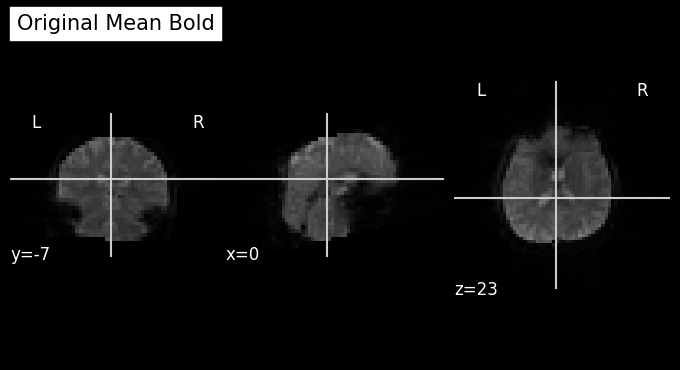

In [31]:
input_bold = os.path.join(base,"data/neurocon/sub-control032014/func/sub-control032014_task-resting_run-1_bold.nii.gz")
plot_anat(average_bold(input_bold).out_file, title="Original Mean Bold", display_mode="ortho")

### SkullStripping

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/data/neurocon/sub-control032014/func/sub-control032014_task-resting_run-1_bold.nii.gz:/styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_14_3dAutomask:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/afni_24.2.06.sif /bin/bash /styx_output/run.sh
[D] Running command: 3dAutomask -prefix desc-brain_mask_bold.nii.gz -apply_prefix desc-brain_bold.nii.gz /styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz
[E] ++ 3dAutomask: AFNI version=AFNI_24.2.06 (Sep 12 2024) [64-bit]
[E] ++ Authored by: Emperor Zhark
[E] *+ WARNING:   If you are performing spatial transformations on an oblique dset,
[E]   such as /styx_input/0/sub-control032014_task-resting_run-1_bold.nii.gz,
[E]   or viewing/combining it with volumes of differing obliquity,
[E]

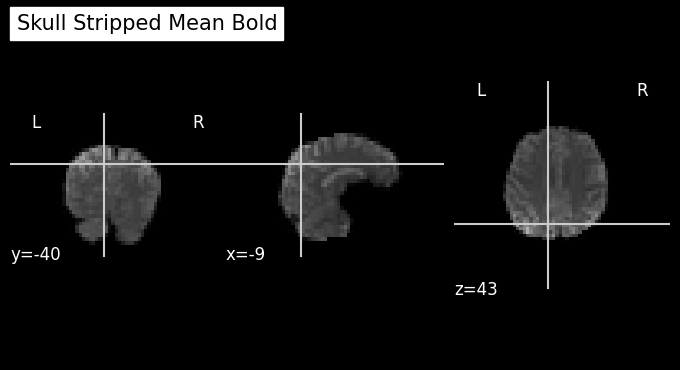

In [37]:
def auto_mask(input_bold):
    out = afni.v_3d_automask(in_file=input_bold, apply_prefix="desc-brain_bold.nii.gz", prefix="desc-brain_mask_bold.nii.gz")
    return out

skull_stripped = auto_mask(input_bold)

average = average_bold(skull_stripped.brain_file)

plot_anat(average.out_file, title="Skull Stripped Mean Bold", display_mode="ortho")

### Motion Correction

[D] Running singularity: singularity exec --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_15_3dTstat/desc-mean_sbref.nii.gz:/styx_input/0/desc-mean_sbref.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_14_3dAutomask/desc-brain_bold.nii.gz:/styx_input/1/desc-brain_bold.nii.gz:ro --bind /ocean/projects/med220004p/bshresth/projects/niwrap-dev/nodeblocks/src/styx_tmp/695529073e261b23_16_3dvolreg:/styx_output /ocean/projects/med220004p/bshresth/projects/niwrap-dev/images/afni_24.2.06.sif /bin/bash /styx_output/run.sh
[D] Running command: 3dvolreg -twopass -Fourier -base /styx_input/0/desc-mean_sbref.nii.gz -zpad 4 -prefix desc-mc_bold.nii.gz -maxdisp1d desc-mc_maxdisp_bold.1D /styx_input/1/desc-brain_bold.nii.gz
[E] ++ 3dvolreg: AFNI version=AFNI_24.2.06 (Sep 12 2024) [64-bit]
[E] ++ Authored by: RW Cox
[E] *+ WARNING:   If you are performing spatial transformations on a

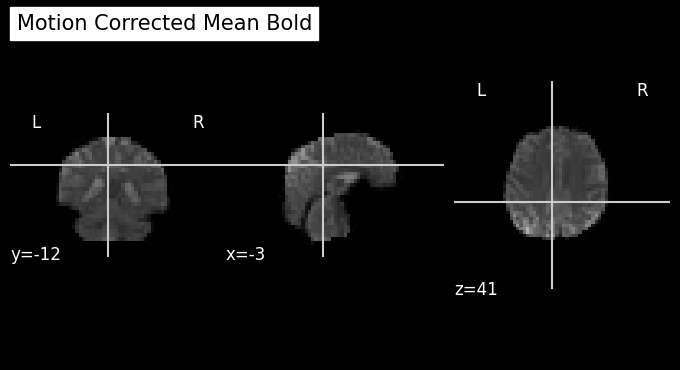

In [38]:
def motion_correction(input_bold, base_file):
    out = afni.v_3dvolreg(in_file=input_bold, 
                          twopass=True,
                          fourier=True,
                          zpad=4,
                          basefile=base_file,
                          prefix="desc-mc_bold.nii.gz",
                          maxdisp1d="desc-mc_maxdisp_bold.1D")
    return out

mc = motion_correction(skull_stripped.brain_file, average.out_file)

plot_anat(average_bold(mc.out_file).out_file, title="Motion Corrected Mean Bold", display_mode="ortho")